In [1]:
# Import các thư viện cần thiết
import os.path as path
from skimage import io
import numpy as np
import scipy as sp
from skimage import color
from skimage import util
import matplotlib.pyplot as plt
import os
from skimage import img_as_ubyte
import torch
from torch.autograd import Variable
from args_fusion import args
import LP as lp
import NestFuse_model as modelNestFuse
import imageio
import glob
import matplotlib.gridspec as gridspec
import cv2

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
fs_type = 'attention_avg'
print("Starting load model")
model_path = args.model_default
model = modelNestFuse.load_model(model_path, False)
model.to(device)

Starting load model
Model NestFuse_autoencoder : params: 10.931044M


c:\PVH\SourceCode\LP+nestfuse\NestFuse_model.py:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  nest_model.load_state_dict(torch.load(path))


NestFuse_autoencoder(
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (up): Upsample(scale_factor=2.0, mode='nearest')
  (up_eval): UpsampleReshape_eval(
    (up): Upsample(scale_factor=2.0, mode='nearest')
  )
  (conv0): ConvLayer(
    (reflection_pad): ReflectionPad2d((0, 0, 0, 0))
    (conv2d): Conv2d(1, 16, kernel_size=(1, 1), stride=(1, 1))
    (dropout): Dropout2d(p=0.5, inplace=False)
  )
  (DB1_0): DenseBlock_light(
    (denseblock): Sequential(
      (0): ConvLayer(
        (reflection_pad): ReflectionPad2d((1, 1, 1, 1))
        (conv2d): Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1))
        (dropout): Dropout2d(p=0.5, inplace=False)
      )
      (1): ConvLayer(
        (reflection_pad): ReflectionPad2d((0, 0, 0, 0))
        (conv2d): Conv2d(8, 64, kernel_size=(1, 1), stride=(1, 1))
        (dropout): Dropout2d(p=0.5, inplace=False)
      )
    )
  )
  (DB2_0): DenseBlock_light(
    (denseblock): Sequential(
      (0): ConvLayer(
    

In [2]:
import math
def get_energy(img):

    vec = img.flatten()
    # Ma trận trọng số là ma trận Guassian 3x3
    W = np.array([[1, 2, 1], [2, 4, 2], [1, 2, 1]]) / 16

    energy = np.sum(W * (img**2))
    return energy

def maximum_region_energy(img_1, img_2, sz_h, sz_w):
     # Khởi tạo ảnh đầu ra với kích thước giống như ảnh đầu vào và đặt giá trị ban đầu bằng 0
    img_output = np.zeros_like(img_1, dtype=np.float32)

    # Resize mask về kích thước ảnh đầu vào
    # salency_mask = cv2.resize(salency_mask, (img_1.shape[1], img_1.shape[0]), interpolation=cv2.INTER_NEAREST)

    # Kích thước cửa sổ trượt
    h = sz_h
    w = sz_w
    ext_x = w // 2
    ext_y = h // 2

    # Mở rộng ảnh đầu vào theo chiều ngang và dọc
    edge_x = np.zeros((img_1.shape[0], ext_x), dtype=np.float32)
    tem_img_1 = np.hstack((edge_x, img_1, edge_x))
    edge_y = np.zeros((ext_y, tem_img_1.shape[1]), dtype=np.float32)
    ext_img_1 = np.vstack((edge_y, tem_img_1, edge_y))

    tem_img_2 = np.hstack((edge_x, img_2, edge_x))
    ext_img_2 = np.vstack((edge_y, tem_img_2, edge_y))

    # Duyệt qua từng pixel của ảnh đầu vào
    for y in range(0, img_1.shape[0]):
        for x in range(0, img_1.shape[1]):
            # Lấy cửa sổ trượt tương ứng từ mỗi ảnh mở rộng
            w_1 = ext_img_1[y:y+2*ext_y+1, x:x+2*ext_x+1]
            w_2 = ext_img_2[y:y+2*ext_y+1, x:x+2*ext_x+1]

            # Tính năng lượng vùng cho từng cửa sổ
            RE1 = abs(get_energy(w_1))
            RE2 = abs(get_energy(w_2))

            # Tính entropy cho từng cửa sổ
            # EN1 = abs(calculate_entropy_window(w_1))
            # EN2 = abs(calculate_entropy_window(w_2))

            # Chiến lược ghép ảnh: chọn pixel từ ảnh có năng lượng vùng cao hơn
            # if (salency_mask[y, x] > 200) or (RE1 >= RE2):
            if (RE1 >= RE2):
                img_output[y, x] = img_1[y, x]
            elif RE1 < RE2:
                img_output[y, x] = img_2[y, x]
                # if EN1 >= EN2:
                #     img_output[y, x] = img_1[y, x]
                # else:
                #     img_output[y, x] = img_2[y, x]

    return img_output

def solution_2_1(pyr_1, pyr_2):
    return maximum_region_energy(pyr_1, pyr_2, sz_h=3, sz_w=3)

# Phương pháp tổng hợp số 1
# def solution_2_1(img_1, img_2, sz_h = 5, sz_w = 5):
#     img_1 = img_1.astype(np.float32)
#     img_2 = img_2.astype(np.float32)
#     img_output = np.zeros(np.shape(img_1), dtype=np.float32)
#     h = sz_h
#     w = sz_w
#     ext_x = int(w / 2)
#     ext_y = int(h / 2)

#     edge_x = np.zeros([img_1.shape[0], ext_x], dtype=np.float32)
#     tem_img_1 = np.hstack((edge_x, img_1, edge_x))
#     edge_y = np.zeros([ext_y, tem_img_1.shape[1]], dtype=np.float32)
#     ext_img_1 = np.vstack((edge_y, tem_img_1, edge_y))
#     tem_img_2 = np.hstack((edge_x, img_2, edge_x))
#     ext_img_2 = np.vstack((edge_y, tem_img_2, edge_y))

#     for y in range(0, img_1.shape[0]):
#         for x in range(0, img_1.shape[1]):
#             w_1 = ext_img_1[y:y+2*ext_y+1, x:x+2*ext_x+1]
#             w_2 = ext_img_2[y:y+2*ext_y+1, x:x+2*ext_x+1]
#             D1 = np.std(w_1)
#             D2 = np.std(w_2)
#             E1 = calculate_entropy(w_1)
#             E2 = calculate_entropy(w_2)
            
#             if D1 >= D2 and E1 >= E2:
#                 img_output[y, x] = img_1[y, x]
#             elif D1 < D2 and E1 < E2:
#                 img_output[y, x] = img_2[y, x]
#             else:
#                 img_output[y, x] = (img_1[y, x] + img_2[y, x]) / 2

#     return img_output

In [3]:
import numpy as np
from skimage import io, img_as_ubyte
from scipy.ndimage import gaussian_filter
from scipy.ndimage import convolve

# Hàm tính entropy 
def calculate_entropy_window(window):
    window = window.flatten()
    unique, counts = np.unique(window, return_counts=True)
    probabilities = counts / np.sum(counts)
    entropy = -np.sum(probabilities * np.log2(probabilities + 1e-10))
    return entropy

def calculate_entropy(image, window_size=5):
    """Tính entropy cục bộ với việc mở rộng biên bằng 0"""
    pad_size = window_size // 2
    padded_image = np.pad(image, pad_size, mode='constant', constant_values=0)
    entropy_map = np.zeros_like(image, dtype=np.float32)
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            region = padded_image[i:i + window_size, j:j + window_size]
            entropy_map[i, j] = calculate_entropy_window(region) / 8.0
    return entropy_map

def calculate_contrast(image, window_size=5):
    """Tính độ tương phản cục bộ với việc mở rộng biên bằng 0"""
    pad_size = window_size // 2
    padded_image = np.pad(image, pad_size, mode='constant', constant_values=0)
    contrast_map = np.zeros_like(image, dtype=np.float32)
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            region = padded_image[i:i + window_size, j:j + window_size]
            contrast_map[i, j] = np.std(region)
    return contrast_map

def gaussian_kernel(size, sigma):
    """Tạo kernel Gaussian 2D."""
    ax = np.linspace(-(size // 2), size // 2, size)
    gauss = np.exp(-0.5 * np.square(ax) / np.square(sigma))
    kernel = np.outer(gauss, gauss)
    return kernel / np.sum(kernel)

def calculate_visibility(image, sigma1=2, sigma2=2, window_size=5):
    """Tính khả năng hiển thị (visibility) theo công thức chính xác."""
    # Tạo kernel Gaussian với σ1
    gM_sigma1 = gaussian_kernel(window_size, sigma1)
    # Làm mờ ảnh gốc
    I_blur = convolve(image, gM_sigma1, mode='constant', cval=0)
    
    # Tính hiệu bình phương (I - I_blur)^2
    difference_squared = (image - I_blur) ** 2
    
    # Tạo kernel Gaussian với σ2
    gM_sigma2 = gaussian_kernel(window_size, sigma2)
    # Làm mờ hiệu bình phương
    visibility_map = convolve(difference_squared, gM_sigma2, mode='constant', cval=0)
    
    # Trả về căn bậc hai của kết quả
    return np.sqrt(visibility_map)

def normalize_weights(weights):
    """Chuẩn hóa trọng số"""
    sum_weights = np.sum(weights, axis=0)
    normalized_weights = weights / (sum_weights + 1e-8)
    return normalized_weights

def solution_3(img1, img2):
    """Hàm tổng hợp hình ảnh"""
    # Tính các thành phần trọng số cho từng ảnh
    H1, H2 = calculate_entropy(img1), calculate_entropy(img2)
    C1, C2 = calculate_contrast(img1), calculate_contrast(img2)
    V1, V2 = calculate_visibility(img1), calculate_visibility(img2)
    
    # Tính trọng số tổng hợp
    alpha = 1
    W1 = (H1 ** alpha) * (C1 ** alpha) * (V1 ** alpha)
    W2 = (H2 ** alpha) * (C2 ** alpha) * (V2 ** alpha)
    
    # Chuẩn hóa trọng số
    W1_normalized, W2_normalized = normalize_weights(np.array([W1, W2]))
    
    # Tổng hợp ảnh dựa trên trọng số
    fused_image = W1_normalized * img1 + W2_normalized * img2
    return fused_image

In [7]:
def calculate_average_gradient(image, solution = 'none'):
    if solution == 'none':
        # formula: mean(sqrt(((I(x+1, y) - I(x, y))^2 + (I(x, y+1) - I(x, y))^2)/2))
        # Đồng bộ kích thước của dx và dy
        dx = image[:-1, 1:] - image[:-1, :-1]
        dy = image[1:, :-1] - image[:-1, :-1]
        gradient = np.sqrt((dx ** 2 + dy ** 2) / 2)
        average_gradient = np.mean(gradient)
    elif solution == 'sobel':
        dx = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=3)
        dy = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=3)
        gradient = np.sqrt((dx ** 2 + dy ** 2) / 2)
        average_gradient = np.mean(gradient)

    return average_gradient

def solution_AG(img1, img2):
    AG1 = calculate_average_gradient(img1)
    AG2 = calculate_average_gradient(img2)
    w1 = AG1 / (AG1 + AG2)
    w2 = AG2 / (AG1 + AG2)
    return w1 * img1 + w2 * img2

In [8]:
from decompose.clahe import adaptive_clahe
from decompose.laplace import laplacian_sharpening_dynamic
from pathlib import Path
from utils_unet.saliency import Saliency

# Hàm tổng hợp hình ảnh
def get_test_image(image):
    images = []
    image = normalize_to_dynamic_range(image, 0, 255)
    image = np.reshape(image, [1, image.shape[0], image.shape[1]])
    images.append(image)
    images = np.stack(images, axis=0)
    image = torch.from_numpy(images).float().to(device)
    return image

def normalize_to_dynamic_range(layer, target_min=0, target_max=1):
    layer_min = layer.min()
    layer_max = layer.max()
    if layer_max == layer_min:
        return np.full(layer.shape, (target_min + target_max) / 2)
    else:
        normalized_layer = (layer - layer_min) / (layer_max - layer_min)
        normalized_layer = normalized_layer * (target_max - target_min) + target_min
        return normalized_layer

# Convert về dạng 8-bit và lưu ảnh
def convert_to_uint_255(layer):
    norm_layer = (layer - np.min(layer)) / (np.max(layer) - np.min(layer))  # Normalize to 0-1 range
    norm_layer = (norm_layer * 255).astype(np.uint8)  # Convert to uint8
    return norm_layer
    
def process_image_pair(ir_path, vis_path, model, output_path, fs_type, pair_id, prefix):

    img_ir = io.imread(ir_path)
    img_vis = io.imread(vis_path)

    if len(img_ir.shape) == 3:
        img_ir = color.rgb2gray(img_ir)
    if len(img_vis.shape) == 3:
        img_vis = color.rgb2gray(img_vis)
    
    img_ir_origin = util.img_as_float(img_ir)
    img_vis_origin = util.img_as_float(img_vis)

    # img_ir_origin = img_ir_origin / 255.0
    # img_vis_origin = img_vis_origin / 255.0
    
    max_levels = 5

    pyramid_ir = lp.laplacian_pyramid.decompose(img_ir_origin, levels=max_levels)
    pyramid_vis = lp.laplacian_pyramid.decompose(img_vis_origin, levels=max_levels)
    
    pyramid_detail_fusion = [None] * (max_levels - 1)
    for i in range(1, max_levels):
        pyramid_detail_fusion[i - 1] = solution_AG(pyramid_ir[i], pyramid_vis[i])
        pyramid_detail_fusion[i - 1] = normalize_to_dynamic_range(pyramid_detail_fusion[i - 1], 0, 1)

    fused_pyramid = [None] * max_levels
    fused_pyramid[0] = solution_2_1(pyramid_ir[0], pyramid_vis[0])
    fused_pyramid[1:] = pyramid_detail_fusion
    
    fused_image = lp.laplacian_pyramid.reconstruct(fused_pyramid)
    output_path_fused = os.path.join(output_path, "fused_image.png")
    io.imsave(output_path_fused, img_as_ubyte(np.clip(fused_image, 0, 1)))
    print(output_path_fused)

    # Lưu pyramid_ir[0], pyramid_vis[0] và fused_pyramid[0] để so sánh
    pyramid_ir_0 = os.path.join(output_path, "ir.png")
    pyramid_vis_0 = os.path.join(output_path, "vis.png")
    fused_pyramid_0 = os.path.join(output_path, "fused.png")

    pyramid_ir_convert = convert_to_uint_255(pyramid_ir[0])
    pyramid_vis_convert = convert_to_uint_255(pyramid_vis[0])
    fused_pyramid_convert = convert_to_uint_255( fused_pyramid[0])

    io.imsave(pyramid_ir_0, pyramid_ir_convert)
    io.imsave(pyramid_vis_0, pyramid_vis_convert)
    io.imsave(fused_pyramid_0, fused_pyramid_convert)

    # Lưu toàn bộ các hình ảnh trong fused_pyramid để so sánh
    for i in range(0, len(fused_pyramid)):
        output_path_fused = os.path.join(output_path, f"fused_{i}.png")
        io.imsave(output_path_fused, img_as_ubyte(np.clip(fused_pyramid[i], 0, 1)))

def find_matching_images(ir_folder, vis_folder):
    ir_images = {os.path.basename(path): path for path in glob.glob(os.path.join(ir_folder, '*.png'))}
    vis_images = {os.path.basename(path): path for path in glob.glob(os.path.join(vis_folder, '*.png'))}
    common_names = sorted(set(ir_images.keys()).intersection(set(vis_images.keys())))
    matching_pairs = [(ir_images[name], vis_images[name]) for name in common_names]
    return matching_pairs

def process_images(ir_folder, vis_folder, output_folder, model, fs_type, prefix):
    os.makedirs(output_folder, exist_ok=True)
    image_pairs = find_matching_images(ir_folder, vis_folder)
    for ir_path, vis_path in image_pairs:
        output_filename = os.path.basename(ir_path)
        # output_path = os.path.join(output_folder, output_filename)
        file_name_not_ext = os.path.splitext(output_filename)[0]
        output_path_folder = os.path.join(output_folder, file_name_not_ext)
        os.makedirs(output_path_folder, exist_ok=True)
        process_image_pair(ir_path, vis_path, model, output_path_folder, fs_type, output_filename, prefix)
        print(f"Processed and saved fusion image to {output_path_folder}")

In [9]:
dataset_choice = 'TNO'
ir_folder = 'C:/PVH/SourceCode/LP+nestfuse/TNO/ir'
vis_folder = 'C:/PVH/SourceCode/LP+nestfuse/TNO/vi'
output_folder = 'C:/PVH/SourceCode/LP+nestfuse/TNO_results/Detail_strategy/AG'
prefix = 'tno'
process_images(ir_folder, vis_folder, output_folder, model, fs_type, prefix)

C:/PVH/SourceCode/LP+nestfuse/TNO_results/Detail_strategy/AG\01\fused_image.png
Processed and saved fusion image to C:/PVH/SourceCode/LP+nestfuse/TNO_results/Detail_strategy/AG\01
C:/PVH/SourceCode/LP+nestfuse/TNO_results/Detail_strategy/AG\02\fused_image.png
Processed and saved fusion image to C:/PVH/SourceCode/LP+nestfuse/TNO_results/Detail_strategy/AG\02
C:/PVH/SourceCode/LP+nestfuse/TNO_results/Detail_strategy/AG\03\fused_image.png
Processed and saved fusion image to C:/PVH/SourceCode/LP+nestfuse/TNO_results/Detail_strategy/AG\03
C:/PVH/SourceCode/LP+nestfuse/TNO_results/Detail_strategy/AG\04\fused_image.png


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_24728\2446536131.py:76: UserWarning: C:/PVH/SourceCode/LP+nestfuse/TNO_results/Detail_strategy/AG\04\ir.png is a low contrast image
  io.imsave(pyramid_ir_0, pyramid_ir_convert)


Processed and saved fusion image to C:/PVH/SourceCode/LP+nestfuse/TNO_results/Detail_strategy/AG\04
C:/PVH/SourceCode/LP+nestfuse/TNO_results/Detail_strategy/AG\05\fused_image.png
Processed and saved fusion image to C:/PVH/SourceCode/LP+nestfuse/TNO_results/Detail_strategy/AG\05
C:/PVH/SourceCode/LP+nestfuse/TNO_results/Detail_strategy/AG\06\fused_image.png
Processed and saved fusion image to C:/PVH/SourceCode/LP+nestfuse/TNO_results/Detail_strategy/AG\06
C:/PVH/SourceCode/LP+nestfuse/TNO_results/Detail_strategy/AG\07\fused_image.png
Processed and saved fusion image to C:/PVH/SourceCode/LP+nestfuse/TNO_results/Detail_strategy/AG\07
C:/PVH/SourceCode/LP+nestfuse/TNO_results/Detail_strategy/AG\08\fused_image.png
Processed and saved fusion image to C:/PVH/SourceCode/LP+nestfuse/TNO_results/Detail_strategy/AG\08
C:/PVH/SourceCode/LP+nestfuse/TNO_results/Detail_strategy/AG\09\fused_image.png
Processed and saved fusion image to C:/PVH/SourceCode/LP+nestfuse/TNO_results/Detail_strategy/AG\09


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_24728\2446536131.py:83: UserWarning: C:/PVH/SourceCode/LP+nestfuse/TNO_results/Detail_strategy/AG\12\fused_0.png is a low contrast image
  io.imsave(output_path_fused, img_as_ubyte(np.clip(fused_pyramid[i], 0, 1)))


C:/PVH/SourceCode/LP+nestfuse/TNO_results/Detail_strategy/AG\13\fused_image.png
Processed and saved fusion image to C:/PVH/SourceCode/LP+nestfuse/TNO_results/Detail_strategy/AG\13


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_24728\2446536131.py:83: UserWarning: C:/PVH/SourceCode/LP+nestfuse/TNO_results/Detail_strategy/AG\13\fused_0.png is a low contrast image
  io.imsave(output_path_fused, img_as_ubyte(np.clip(fused_pyramid[i], 0, 1)))


C:/PVH/SourceCode/LP+nestfuse/TNO_results/Detail_strategy/AG\14\fused_image.png
Processed and saved fusion image to C:/PVH/SourceCode/LP+nestfuse/TNO_results/Detail_strategy/AG\14
C:/PVH/SourceCode/LP+nestfuse/TNO_results/Detail_strategy/AG\15\fused_image.png


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_24728\2446536131.py:83: UserWarning: C:/PVH/SourceCode/LP+nestfuse/TNO_results/Detail_strategy/AG\15\fused_0.png is a low contrast image
  io.imsave(output_path_fused, img_as_ubyte(np.clip(fused_pyramid[i], 0, 1)))


Processed and saved fusion image to C:/PVH/SourceCode/LP+nestfuse/TNO_results/Detail_strategy/AG\15
C:/PVH/SourceCode/LP+nestfuse/TNO_results/Detail_strategy/AG\16\fused_image.png
Processed and saved fusion image to C:/PVH/SourceCode/LP+nestfuse/TNO_results/Detail_strategy/AG\16
C:/PVH/SourceCode/LP+nestfuse/TNO_results/Detail_strategy/AG\17\fused_image.png
Processed and saved fusion image to C:/PVH/SourceCode/LP+nestfuse/TNO_results/Detail_strategy/AG\17
C:/PVH/SourceCode/LP+nestfuse/TNO_results/Detail_strategy/AG\18\fused_image.png
Processed and saved fusion image to C:/PVH/SourceCode/LP+nestfuse/TNO_results/Detail_strategy/AG\18
C:/PVH/SourceCode/LP+nestfuse/TNO_results/Detail_strategy/AG\19\fused_image.png
Processed and saved fusion image to C:/PVH/SourceCode/LP+nestfuse/TNO_results/Detail_strategy/AG\19
C:/PVH/SourceCode/LP+nestfuse/TNO_results/Detail_strategy/AG\20\fused_image.png
Processed and saved fusion image to C:/PVH/SourceCode/LP+nestfuse/TNO_results/Detail_strategy/AG\20


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_24728\2446536131.py:83: UserWarning: C:/PVH/SourceCode/LP+nestfuse/TNO_results/Detail_strategy/AG\22\fused_0.png is a low contrast image
  io.imsave(output_path_fused, img_as_ubyte(np.clip(fused_pyramid[i], 0, 1)))


C:/PVH/SourceCode/LP+nestfuse/TNO_results/Detail_strategy/AG\23\fused_image.png
Processed and saved fusion image to C:/PVH/SourceCode/LP+nestfuse/TNO_results/Detail_strategy/AG\23
C:/PVH/SourceCode/LP+nestfuse/TNO_results/Detail_strategy/AG\24\fused_image.png


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_24728\2446536131.py:83: UserWarning: C:/PVH/SourceCode/LP+nestfuse/TNO_results/Detail_strategy/AG\24\fused_0.png is a low contrast image
  io.imsave(output_path_fused, img_as_ubyte(np.clip(fused_pyramid[i], 0, 1)))


Processed and saved fusion image to C:/PVH/SourceCode/LP+nestfuse/TNO_results/Detail_strategy/AG\24
C:/PVH/SourceCode/LP+nestfuse/TNO_results/Detail_strategy/AG\25\fused_image.png
Processed and saved fusion image to C:/PVH/SourceCode/LP+nestfuse/TNO_results/Detail_strategy/AG\25
C:/PVH/SourceCode/LP+nestfuse/TNO_results/Detail_strategy/AG\26\fused_image.png
Processed and saved fusion image to C:/PVH/SourceCode/LP+nestfuse/TNO_results/Detail_strategy/AG\26
C:/PVH/SourceCode/LP+nestfuse/TNO_results/Detail_strategy/AG\27\fused_image.png


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_24728\2446536131.py:83: UserWarning: C:/PVH/SourceCode/LP+nestfuse/TNO_results/Detail_strategy/AG\27\fused_0.png is a low contrast image
  io.imsave(output_path_fused, img_as_ubyte(np.clip(fused_pyramid[i], 0, 1)))


Processed and saved fusion image to C:/PVH/SourceCode/LP+nestfuse/TNO_results/Detail_strategy/AG\27
C:/PVH/SourceCode/LP+nestfuse/TNO_results/Detail_strategy/AG\28\fused_image.png


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_24728\2446536131.py:83: UserWarning: C:/PVH/SourceCode/LP+nestfuse/TNO_results/Detail_strategy/AG\28\fused_0.png is a low contrast image
  io.imsave(output_path_fused, img_as_ubyte(np.clip(fused_pyramid[i], 0, 1)))


Processed and saved fusion image to C:/PVH/SourceCode/LP+nestfuse/TNO_results/Detail_strategy/AG\28
C:/PVH/SourceCode/LP+nestfuse/TNO_results/Detail_strategy/AG\29\fused_image.png
Processed and saved fusion image to C:/PVH/SourceCode/LP+nestfuse/TNO_results/Detail_strategy/AG\29


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_24728\2446536131.py:83: UserWarning: C:/PVH/SourceCode/LP+nestfuse/TNO_results/Detail_strategy/AG\29\fused_0.png is a low contrast image
  io.imsave(output_path_fused, img_as_ubyte(np.clip(fused_pyramid[i], 0, 1)))


C:/PVH/SourceCode/LP+nestfuse/TNO_results/Detail_strategy/AG\30\fused_image.png
Processed and saved fusion image to C:/PVH/SourceCode/LP+nestfuse/TNO_results/Detail_strategy/AG\30
C:/PVH/SourceCode/LP+nestfuse/TNO_results/Detail_strategy/AG\31\fused_image.png
Processed and saved fusion image to C:/PVH/SourceCode/LP+nestfuse/TNO_results/Detail_strategy/AG\31
C:/PVH/SourceCode/LP+nestfuse/TNO_results/Detail_strategy/AG\32\fused_image.png
Processed and saved fusion image to C:/PVH/SourceCode/LP+nestfuse/TNO_results/Detail_strategy/AG\32
C:/PVH/SourceCode/LP+nestfuse/TNO_results/Detail_strategy/AG\33\fused_image.png


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_24728\2446536131.py:83: UserWarning: C:/PVH/SourceCode/LP+nestfuse/TNO_results/Detail_strategy/AG\33\fused_0.png is a low contrast image
  io.imsave(output_path_fused, img_as_ubyte(np.clip(fused_pyramid[i], 0, 1)))


Processed and saved fusion image to C:/PVH/SourceCode/LP+nestfuse/TNO_results/Detail_strategy/AG\33
C:/PVH/SourceCode/LP+nestfuse/TNO_results/Detail_strategy/AG\34\fused_image.png
Processed and saved fusion image to C:/PVH/SourceCode/LP+nestfuse/TNO_results/Detail_strategy/AG\34
C:/PVH/SourceCode/LP+nestfuse/TNO_results/Detail_strategy/AG\35\fused_image.png
Processed and saved fusion image to C:/PVH/SourceCode/LP+nestfuse/TNO_results/Detail_strategy/AG\35
C:/PVH/SourceCode/LP+nestfuse/TNO_results/Detail_strategy/AG\36\fused_image.png
Processed and saved fusion image to C:/PVH/SourceCode/LP+nestfuse/TNO_results/Detail_strategy/AG\36
C:/PVH/SourceCode/LP+nestfuse/TNO_results/Detail_strategy/AG\37\fused_image.png


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_24728\2446536131.py:83: UserWarning: C:/PVH/SourceCode/LP+nestfuse/TNO_results/Detail_strategy/AG\37\fused_0.png is a low contrast image
  io.imsave(output_path_fused, img_as_ubyte(np.clip(fused_pyramid[i], 0, 1)))


Processed and saved fusion image to C:/PVH/SourceCode/LP+nestfuse/TNO_results/Detail_strategy/AG\37
C:/PVH/SourceCode/LP+nestfuse/TNO_results/Detail_strategy/AG\38\fused_image.png
Processed and saved fusion image to C:/PVH/SourceCode/LP+nestfuse/TNO_results/Detail_strategy/AG\38
C:/PVH/SourceCode/LP+nestfuse/TNO_results/Detail_strategy/AG\39\fused_image.png
Processed and saved fusion image to C:/PVH/SourceCode/LP+nestfuse/TNO_results/Detail_strategy/AG\39
C:/PVH/SourceCode/LP+nestfuse/TNO_results/Detail_strategy/AG\40\fused_image.png
Processed and saved fusion image to C:/PVH/SourceCode/LP+nestfuse/TNO_results/Detail_strategy/AG\40
C:/PVH/SourceCode/LP+nestfuse/TNO_results/Detail_strategy/AG\41\fused_image.png
Processed and saved fusion image to C:/PVH/SourceCode/LP+nestfuse/TNO_results/Detail_strategy/AG\41
C:/PVH/SourceCode/LP+nestfuse/TNO_results/Detail_strategy/AG\42\fused_image.png
Processed and saved fusion image to C:/PVH/SourceCode/LP+nestfuse/TNO_results/Detail_strategy/AG\42


In [10]:
from Indicator.show_indicator import show_indicator_csv

# list_code_image = [1, 2, 4, 6, 9, 10, 12, 13, 19, 20]

# Tạo file csv chứa kết quả đánh giá tổng hợp cho cả 10 nhóm ảnh trên
import csv
import pandas as pd
import os
from skimage import io

# Tạo file csv chứa kết quả đánh giá tổng hợp cho cả 10 nhóm ảnh trên
output_folder = 'C:/PVH/SourceCode/LP+nestfuse/TNO_results/Detail_strategy/AG'

def create_csv_file(output_folder):
    # Tạo file csv chứa kết quả đánh giá tổng hợp cho cả 10 nhóm ảnh trên (kết quả lấy từ hàm show_indicator)
    csv_file = os.path.join(output_folder, 'result.csv')
    with open(csv_file, mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(['Code', 'MI', 'NMI', 'NCIE', 'QG', 'QM', 'SSIM', 'Qs_Piella', 'Qw_Piella', 'Qe_Piella', 'Yang', 'PSNR', 'EN', 'AG', 'SD', 'ALI', 'CC', 'VIF'])
        # for code in list_code_image:
        for number_image in range(1, 43):
            if number_image < 10:
                code = f'0{number_image}'
            else:
                code = f'{number_image}'
            ir = io.imread(f'C:/PVH/SourceCode/LP+nestfuse/TNO/ir/{code}.png')
            vi = io.imread(f'C:/PVH/SourceCode/LP+nestfuse/TNO/vi/{code}.png')
            fused = io.imread(f'C:/PVH/SourceCode/LP+nestfuse/TNO_results/Detail_strategy/AG/{code}/fused_image.png')
            MI, NMI, NCIE, QG, QM, SSIM, Qs_Piella, Qw_Piella, Qe_Piella, Yang, PSNR, EN, AG, SD, ALI, CC, VIF = show_indicator_csv(f"{code}", ir, vi, fused)
            writer.writerow([code, MI, NMI, NCIE, QG, QM, SSIM, Qs_Piella, Qw_Piella, Qe_Piella, Yang, PSNR, EN, AG, SD, ALI, CC, VIF])
            print(f"Done {code}")
        
    # Check if the CSV file is empty before reading it
    if os.path.getsize(csv_file) > 0:
        # Tính trung bình cộng của các chỉ số đánh giá
        df = pd.read_csv(csv_file)
        avg = df.mean()
        with open(csv_file, mode='a', newline='') as file:
            writer = csv.writer(file)
            writer.writerow(['Average', avg['MI'], avg['NMI'], avg['NCIE'], avg['QG'], avg['QM'], avg['SSIM'], avg['Qs_Piella'], avg['Qw_Piella'], avg['Qe_Piella'], avg['Yang'], avg['PSNR'], avg['EN'], avg['AG'], avg['SD'], avg['ALI'], avg['CC'], avg['VIF']]) 

    # Chuyển file csv thành file excel
    df = pd.read_csv(csv_file)
    df.to_excel(os.path.join(output_folder, 'result.xlsx'), index = False)

create_csv_file(output_folder)

Done 01
Done 02
Done 03
Done 04
Done 05
Done 06
Done 07
Done 08
Done 09
Done 10
Done 11
Done 12
Done 13
Done 14
Done 15
Done 16
Done 17
Done 18
Done 19
Done 20
Done 21
Done 22
Done 23
Done 24
Done 25
Done 26
Done 27
Done 28
Done 29
Done 30
Done 31
Done 32
Done 33
Done 34
Done 35
Done 36
Done 37
Done 38
Done 39
Done 40
Done 41
Done 42


In [14]:
from Indicator.show_indicator import show_indicator_csv

# list_code_image = [1, 2, 4, 6, 9, 10, 12, 13, 19, 20]

# Tạo file csv chứa kết quả đánh giá tổng hợp cho cả 10 nhóm ảnh trên
import csv
import pandas as pd
import os
from skimage import io

# Tạo file csv chứa kết quả đánh giá tổng hợp cho cả 10 nhóm ảnh trên
output_folder = 'C:/PVH/SourceCode/LP+nestfuse/TNO_results/Base_strategy/pp_1'

def create_csv_file(output_folder):
    # Tạo file csv chứa kết quả đánh giá tổng hợp cho cả 10 nhóm ảnh trên (kết quả lấy từ hàm show_indicator)
    csv_file = os.path.join(output_folder, 'result_mask.csv')
    with open(csv_file, mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(['Code', 'MI', 'NMI', 'NCIE', 'QG', 'QM', 'SSIM', 'Qs_Piella', 'Qw_Piella', 'Qe_Piella', 'Yang', 'PSNR', 'EN', 'AG', 'SD', 'ALI', 'CC', 'VIF'])
        # for code in list_code_image:
        for number_image in range(1, 43):
            if number_image < 10:
                code = f'0{number_image}'
            else:
                code = f'{number_image}'
            ir = io.imread(f'C:/PVH/SourceCode/LP+nestfuse/TNO/ir/{code}.png')
            vi = io.imread(f'C:/PVH/SourceCode/LP+nestfuse/TNO/vi/{code}.png')
            fused = io.imread(f'C:/PVH/SourceCode/LP+nestfuse/TNO_results/Base_strategy/pp_1/{code}/fused_image_add_IR_mask.png')
            MI, NMI, NCIE, QG, QM, SSIM, Qs_Piella, Qw_Piella, Qe_Piella, Yang, PSNR, EN, AG, SD, ALI, CC, VIF = show_indicator_csv(f"{code}", ir, vi, fused)
            writer.writerow([code, MI, NMI, NCIE, QG, QM, SSIM, Qs_Piella, Qw_Piella, Qe_Piella, Yang, PSNR, EN, AG, SD, ALI, CC, VIF])
            print(f"Done {code}")
        
    # Check if the CSV file is empty before reading it
    if os.path.getsize(csv_file) > 0:
        # Tính trung bình cộng của các chỉ số đánh giá
        df = pd.read_csv(csv_file)
        avg = df.mean()
        with open(csv_file, mode='a', newline='') as file:
            writer = csv.writer(file)
            writer.writerow(['Average', avg['MI'], avg['NMI'], avg['NCIE'], avg['QG'], avg['QM'], avg['SSIM'], avg['Qs_Piella'], avg['Qw_Piella'], avg['Qe_Piella'], avg['Yang'], avg['PSNR'], avg['EN'], avg['AG'], avg['SD'], avg['ALI'], avg['CC'], avg['VIF']]) 

    # Chuyển file csv thành file excel
    df = pd.read_csv(csv_file)
    df.to_excel(os.path.join(output_folder, 'result_mask.xlsx'), index = False)

create_csv_file(output_folder)

Done 01
Done 02
Done 03
Done 04
Done 05
Done 06
Done 07
Done 08
Done 09
Done 10
Done 11
Done 12
Done 13
Done 14
Done 15
Done 16
Done 17
Done 18
Done 19
Done 20
Done 21
Done 22
Done 23
Done 24
Done 25
Done 26
Done 27
Done 28
Done 29
Done 30
Done 31
Done 32
Done 33
Done 34
Done 35
Done 36
Done 37
Done 38
Done 39
Done 40
Done 41
Done 42


In [5]:
output_folder = 'C:/PVH/SourceCode/LP+nestfuse/TEST_BASED_results/deep_model/loss_with_mssim_algebra_wight_1'

In [5]:
output_folder = 'C:/PVH/SourceCode/LP+nestfuse/TEST_BASED_results/deep_model/msrs_image_aug'

In [ ]:
from Indicator.show_indicator import show_indicator_csv

list_code_image = [1, 2, 4, 6, 9, 10, 12, 13, 19, 20]

# Tạo file csv chứa kết quả đánh giá tổng hợp cho cả 10 nhóm ảnh trên
import csv
import pandas as pd

# Tạo file csv chứa kết quả đánh giá tổng hợp cho cả 10 nhóm ảnh trên
def create_csv_file(list_code_image, output_folder):
    # Tạo file csv chứa kết quả đánh giá tổng hợp cho cả 10 nhóm ảnh trên (kết quả lấy từ hàm show_indicator)
    csv_file = os.path.join(output_folder, 'result.csv')
    with open(csv_file, mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(['Code', 'MI', 'NMI', 'NCIE', 'QG', 'QM', 'SSIM', 'Qs_Piella', 'Qw_Piella', 'Qe_Piella', 'Yang', 'PSNR', 'EN', 'AG', 'SD', 'ALI', 'CC', 'VIF'])
        for code in list_code_image:
            ir = io.imread(f'C:/PVH/SourceCode/LP+nestfuse/images/TEST_BASED/ir/{code}.png')
            vi = io.imread(f'C:/PVH/SourceCode/LP+nestfuse/images/TEST_BASED/vi/{code}.png')
            fused = io.imread(f'C:/PVH/SourceCode/LP+nestfuse/TEST_BASED_results/deep_model/msrs_image_aug/{code}/fused_image.png')
            MI, NMI, NCIE, QG, QM, SSIM, Qs_Piella, Qw_Piella, Qe_Piella, Yang, PSNR, EN, AG, SD, ALI, CC, VIF = show_indicator_csv(f"{code}", ir, vi, fused)
            writer.writerow([code, MI, NMI, NCIE, QG, QM, SSIM, Qs_Piella, Qw_Piella, Qe_Piella, Yang, PSNR, EN, AG, SD, ALI, CC, VIF])
            print(f"Done {code}")
        
    # Check if the CSV file is empty before reading it
    if os.path.getsize(csv_file) > 0:
        # Tính trung bình cộng của các chỉ số đánh giá
        df = pd.read_csv(csv_file)
        avg = df.mean()
        with open(csv_file, mode='a', newline='') as file:
            writer = csv.writer(file)
            writer.writerow(['Average', avg['MI'], avg['NMI'], avg['NCIE'], avg['QG'], avg['QM'], avg['SSIM'], avg['Qs_Piella'], avg['Qw_Piella'], avg['Qe_Piella'], avg['Yang'], avg['PSNR'], avg['EN'], avg['AG'], avg['SD'], avg['ALI'], avg['CC'], avg['VIF']]) 

    # Chuyển file csv thành file excel
    df = pd.read_csv(csv_file)
    df.to_excel(os.path.join(output_folder, 'result.xlsx'), index = False)

create_csv_file(list_code_image, output_folder)

FileNotFoundError: No such file: 'C:\PVH\SourceCode\LP+nestfuse\TNO\ir\1.png'

In [7]:
from Indicator.show_indicator import show_indicator_csv

list_code_image = [1, 2, 4, 6, 9, 10, 12, 13, 19, 20]

# Tạo file csv chứa kết quả đánh giá tổng hợp cho cả 10 nhóm ảnh trên
import csv
import pandas as pd

# Tạo file csv chứa kết quả đánh giá tổng hợp cho cả 10 nhóm ảnh trên
def create_csv_file(list_code_image, output_folder):
    # Tạo file csv chứa kết quả đánh giá tổng hợp cho cả 10 nhóm ảnh trên (kết quả lấy từ hàm show_indicator)
    csv_file = os.path.join(output_folder, 'result_mask.csv')
    with open(csv_file, mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(['Code', 'MI', 'NMI', 'NCIE', 'QG', 'QM', 'SSIM', 'Qs_Piella', 'Qw_Piella', 'Qe_Piella', 'Yang', 'PSNR', 'EN', 'AG', 'SD', 'ALI', 'CC', 'VIF'])
        for code in list_code_image:
            ir = io.imread(f'C:/PVH/SourceCode/LP+nestfuse/images/TEST_BASED/ir/{code}.png')
            vi = io.imread(f'C:/PVH/SourceCode/LP+nestfuse/images/TEST_BASED/vi/{code}.png')
            fused = io.imread(f'C:/PVH/SourceCode/LP+nestfuse/TEST_BASED_results/deep_model/msrs_image_aug/{code}/fused_image_add_IR_mask.png')
            MI, NMI, NCIE, QG, QM, SSIM, Qs_Piella, Qw_Piella, Qe_Piella, Yang, PSNR, EN, AG, SD, ALI, CC, VIF = show_indicator_csv(f"{code}", ir, vi, fused)
            writer.writerow([code, MI, NMI, NCIE, QG, QM, SSIM, Qs_Piella, Qw_Piella, Qe_Piella, Yang, PSNR, EN, AG, SD, ALI, CC, VIF])
            print(f"Done {code}")
        
    # Check if the CSV file is empty before reading it
    if os.path.getsize(csv_file) > 0:
        # Tính trung bình cộng của các chỉ số đánh giá
        df = pd.read_csv(csv_file)
        avg = df.mean()
        with open(csv_file, mode='a', newline='') as file:
            writer = csv.writer(file)
            writer.writerow(['Average', avg['MI'], avg['NMI'], avg['NCIE'], avg['QG'], avg['QM'], avg['SSIM'], avg['Qs_Piella'], avg['Qw_Piella'], avg['Qe_Piella'], avg['Yang'], avg['PSNR'], avg['EN'], avg['AG'], avg['SD'], avg['ALI'], avg['CC'], avg['VIF']]) 

    # Chuyển file csv thành file excel
    df = pd.read_csv(csv_file)
    df.to_excel(os.path.join(output_folder, 'result_mask.xlsx'), index = False)

create_csv_file(list_code_image, output_folder)

Done 1
Done 2
Done 4
Done 6
Done 9
Done 10
Done 12
Done 13
Done 19
Done 20


#### Phương pháp 1: Quy tắc dựa trên thông tin vùng về Độ lệch chuẩn (D) và Entropy (E) 

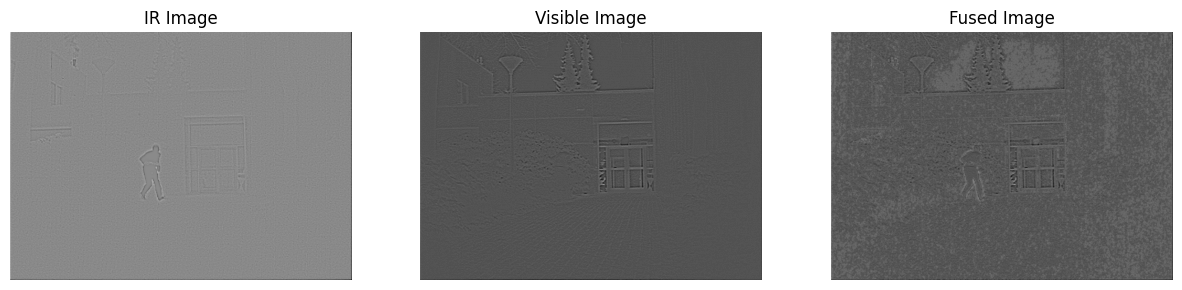

In [ ]:
import numpy as np
from skimage import io
import matplotlib.pyplot as plt
from matplotlib import gridspec

# Hàm tính entropy 
def calculate_entropy(window):
    window = window.flatten()
    unique, counts = np.unique(window, return_counts=True)
    probabilities = counts / np.sum(counts)
    entropy = -np.sum(probabilities * np.log2(probabilities + 1e-10))
    return entropy

# Phương pháp tổng hợp số 1
def solution_1(img_1, img_2, sz_h = 5, sz_w = 5):
    img_1 = img_1.astype(np.float32)
    img_2 = img_2.astype(np.float32)
    img_output = np.zeros(np.shape(img_1), dtype=np.float32)
    h = sz_h
    w = sz_w
    ext_x = int(w / 2)
    ext_y = int(h / 2)

    edge_x = np.zeros([img_1.shape[0], ext_x], dtype=np.float32)
    tem_img_1 = np.hstack((edge_x, img_1, edge_x))
    edge_y = np.zeros([ext_y, tem_img_1.shape[1]], dtype=np.float32)
    ext_img_1 = np.vstack((edge_y, tem_img_1, edge_y))
    tem_img_2 = np.hstack((edge_x, img_2, edge_x))
    ext_img_2 = np.vstack((edge_y, tem_img_2, edge_y))

    for y in range(0, img_1.shape[0]):
        for x in range(0, img_1.shape[1]):
            w_1 = ext_img_1[y:y+2*ext_y+1, x:x+2*ext_x+1]
            w_2 = ext_img_2[y:y+2*ext_y+1, x:x+2*ext_x+1]
            D1 = np.std(w_1)
            D2 = np.std(w_2)
            E1 = calculate_entropy(w_1)
            E2 = calculate_entropy(w_2)
            
            if D1 >= D2 and E1 >= E2:
                img_output[y, x] = img_1[y, x]
            elif D1 < D2 and E1 < E2:
                img_output[y, x] = img_2[y, x]
            else:
                img_output[y, x] = (img_1[y, x] + img_2[y, x]) / 2

    return img_output

# Đọc ảnh
img_1 = io.imread('C:/PVH/SourceCode/LP+nestfuse/TEST_BASED_results/pp2/12/ir.png', as_gray=True)
img_2 = io.imread('C:/PVH/SourceCode/LP+nestfuse/TEST_BASED_results/pp2/12/vis.png', as_gray=True)

# Chuẩn hóa ảnh
img_1 = (img_1 * 255).astype(np.float32)
img_2 = (img_2 * 255).astype(np.float32)

fused_img = solution_1(img_1, img_2, 5, 5)
fused_img = fused_img.astype(np.uint8)

# Hiển thị ảnh
fig = plt.figure(figsize=(15, 15))
gs = gridspec.GridSpec(1, 3)
ax1 = plt.subplot(gs[0]); ax1.imshow(img_1, cmap='gray'); ax1.set_title('IR Image'); ax1.axis('off')
ax2 = plt.subplot(gs[1]); ax2.imshow(img_2, cmap='gray'); ax2.set_title('Visible Image'); ax2.axis('off')
ax3 = plt.subplot(gs[2]); ax3.imshow(fused_img, cmap='gray'); ax3.set_title('Fused Image'); ax3.axis('off')
plt.show()


#### Phương pháp 3

In [ ]:
import numpy as np
from skimage import io, img_as_ubyte
from scipy.ndimage import gaussian_filter
from scipy.ndimage import convolve

# Hàm tính entropy 
def calculate_entropy_window(window):
    window = window.flatten()
    unique, counts = np.unique(window, return_counts=True)
    probabilities = counts / np.sum(counts)
    entropy = -np.sum(probabilities * np.log2(probabilities + 1e-10))
    return entropy

def calculate_entropy(image, window_size=5):
    """Tính entropy cục bộ với việc mở rộng biên bằng 0"""
    pad_size = window_size // 2
    padded_image = np.pad(image, pad_size, mode='constant', constant_values=0)
    entropy_map = np.zeros_like(image, dtype=np.float32)
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            region = padded_image[i:i + window_size, j:j + window_size]
            entropy_map[i, j] = calculate_entropy_window(region) / 8.0
    return entropy_map

def calculate_contrast(image, window_size=5):
    """Tính độ tương phản cục bộ với việc mở rộng biên bằng 0"""
    pad_size = window_size // 2
    padded_image = np.pad(image, pad_size, mode='constant', constant_values=0)
    contrast_map = np.zeros_like(image, dtype=np.float32)
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            region = padded_image[i:i + window_size, j:j + window_size]
            contrast_map[i, j] = np.std(region)
    return contrast_map

def gaussian_kernel(size, sigma):
    """Tạo kernel Gaussian 2D."""
    ax = np.linspace(-(size // 2), size // 2, size)
    gauss = np.exp(-0.5 * np.square(ax) / np.square(sigma))
    kernel = np.outer(gauss, gauss)
    return kernel / np.sum(kernel)

def calculate_visibility(image, sigma1=2, sigma2=2, window_size=5):
    """Tính khả năng hiển thị (visibility) theo công thức chính xác."""
    # Tạo kernel Gaussian với σ1
    gM_sigma1 = gaussian_kernel(window_size, sigma1)
    # Làm mờ ảnh gốc
    I_blur = convolve(image, gM_sigma1, mode='constant', cval=0)
    
    # Tính hiệu bình phương (I - I_blur)^2
    difference_squared = (image - I_blur) ** 2
    
    # Tạo kernel Gaussian với σ2
    gM_sigma2 = gaussian_kernel(window_size, sigma2)
    # Làm mờ hiệu bình phương
    visibility_map = convolve(difference_squared, gM_sigma2, mode='constant', cval=0)
    
    # Trả về căn bậc hai của kết quả
    return np.sqrt(visibility_map)

def normalize_weights(weights):
    """Chuẩn hóa trọng số"""
    sum_weights = np.sum(weights, axis=0)
    normalized_weights = weights / (sum_weights + 1e-8)
    return normalized_weights

def solution_3(img1, img2):
    """Hàm tổng hợp hình ảnh"""
    # Tính các thành phần trọng số cho từng ảnh
    H1, H2 = calculate_entropy(img1), calculate_entropy(img2)
    C1, C2 = calculate_contrast(img1), calculate_contrast(img2)
    V1, V2 = calculate_visibility(img1), calculate_visibility(img2)
    
    # Tính trọng số tổng hợp
    alpha = 1
    W1 = (H1 ** alpha) * (C1 ** alpha) * (V1 ** alpha)
    W2 = (H2 ** alpha) * (C2 ** alpha) * (V2 ** alpha)
    
    # Chuẩn hóa trọng số
    W1_normalized, W2_normalized = normalize_weights(np.array([W1, W2]))
    
    # Tổng hợp ảnh dựa trên trọng số
    fused_image = W1_normalized * img1 + W2_normalized * img2
    return fused_image

#### Phương pháp 5

In [ ]:
def calculate_local_laplacian_energy(img, window_size=5):
    # Kernel Laplacian như trong công thức
    laplacian_kernel = np.array([
        [-1, -4, -1],
        [-4, 20, -4],
        [-1, -4, -1]
    ])
    
    # Tính toán năng lượng Laplacian
    laplacian = cv2.filter2D(img.astype(np.float32), -1, laplacian_kernel)
    local_energy = cv2.boxFilter(laplacian**2, -1, (window_size, window_size))
    
    return local_energy

def solution_5(img_ir, img_vi, window_size=5):
    # Tính năng lượng Laplacian cục bộ
    energy_ir = calculate_local_laplacian_energy(img_ir, window_size)
    energy_vi = calculate_local_laplacian_energy(img_vi, window_size)
    
    # Chuẩn hóa năng lượng Laplacian
    weight_ir = energy_ir / (energy_ir + energy_vi + 1e-8)
    weight_vi = energy_vi / (energy_ir + energy_vi + 1e-8)
    
    # Hợp nhất ảnh dựa trên trọng số
    fused_image = weight_ir * img_ir + weight_vi * img_vi
    
    return fused_image

#### Phương pháp 6 (thực ra là số 8 - ghi nhầm)

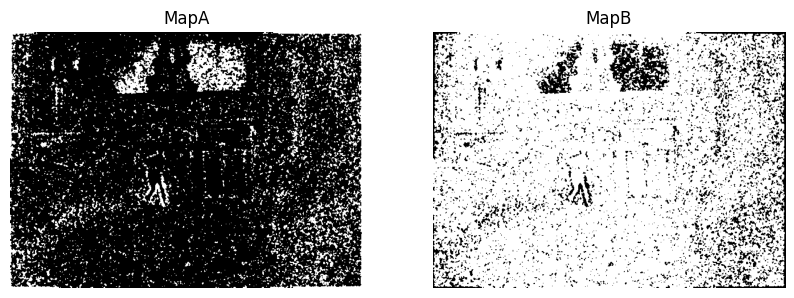

In [20]:
import numpy as np
from scipy.ndimage import convolve

def calculate_emls(image):
    # Ma trận trọng số 3x3 chuẩn hóa
    W = (1/16) * np.array([[1, 2, 1],
                           [2, 4, 2],
                           [1, 2, 1]])

    # Kích thước ảnh
    h, w = image.shape

    # Tính giá trị EMLS
    padded_image = np.pad(image, pad_width=1, mode='reflect')  # Đệm biên
    emls = np.zeros((h, w))

    for i in range(1, h + 1):
        for j in range(1, w + 1):
            # Tính EMLS theo công thức
            emls[i - 1, j - 1] = (
                abs(2 * padded_image[i, j] - padded_image[i - 1, j] - padded_image[i + 1, j]) +
                abs(2 * padded_image[i, j] - padded_image[i, j - 1] - padded_image[i, j + 1]) +
                (1 / np.sqrt(2)) * abs(2 * padded_image[i, j] - padded_image[i - 1, j - 1] - padded_image[i + 1, j + 1]) +
                (1 / np.sqrt(2)) * abs(2 * padded_image[i, j] - padded_image[i - 1, j + 1] - padded_image[i + 1, j - 1])
            )

    padded_elms = np.pad(emls, pad_width=1, mode='reflect')  # Đệm biên
    wemls = np.zeros((h, w))
    for i in range(1, h + 1):
        for j in range(1, w + 1):
            # Tính EMLS theo công thức
            emls_window = padded_elms[i - 1:i + 2, j - 1:j + 2]
            wemls[i - 1, j - 1] = np.sum(emls_window * W)

    return wemls

def generate_weight_maps(image1, image2):
    # Tính mức độ hoạt động cho từng ảnh
    wsem_l1 = calculate_emls(image1)
    wsem_l2 = calculate_emls(image2)

    # Tạo bản đồ trọng số nhị phân
    mapA = (wsem_l1 >= wsem_l2).astype(int)
    mapB = 1 - mapA  # mapB là nghịch đảo của mapA

    return mapA, mapB

# Đọc ảnh
# Đọc ảnh
img_1 = io.imread('C:/PVH/SourceCode/LP+nestfuse/TEST_BASED_results/pp2/12/ir.png', as_gray=True)
img_2 = io.imread('C:/PVH/SourceCode/LP+nestfuse/TEST_BASED_results/pp2/12/vis.png', as_gray=True)

mapA, mapB = generate_weight_maps(img_1, img_2)

# Dùng maplotlib hiển thị mapA và mapB
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1); plt.imshow(mapA, cmap='gray'); plt.title('MapA'); plt.axis('off')
plt.subplot(1, 2, 2); plt.imshow(mapB, cmap='gray'); plt.title('MapB'); plt.axis('off')
plt.show()

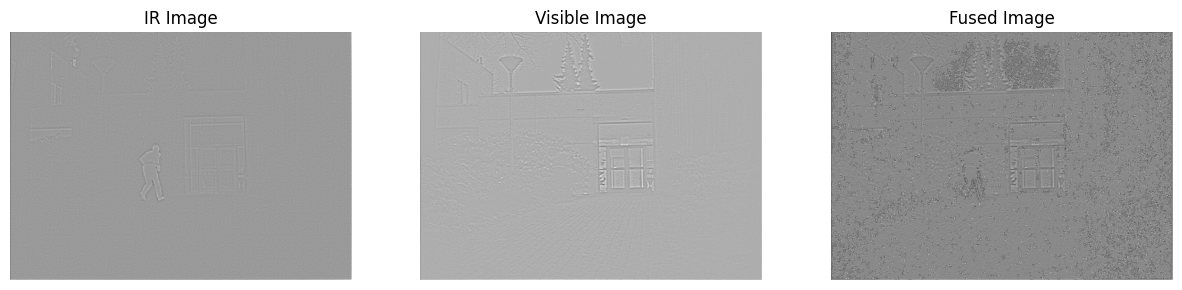

In [ ]:
def guided_filtering(I, p, r = 3, eps = 0.01):
    h, w = I.shape
    padded_image = np.pad(I, pad_width=1, mode='reflect')  # Đệm biên
    padded_p = np.pad(p, pad_width=1, mode='reflect')  # Đệm biên
    guided = np.zeros((h, w))

    for i in range(1, h + 1):
        for j in range(1, w + 1):
            # Tính EMLS theo công thức
            I_window = padded_image[i - 1:i + 2, j - 1:j + 2]
            p_window = padded_p[i - 1:i + 2, j - 1:j + 2]

            # Tính hiệp phương sai giữa I_window và p_window
            mean_I = np.mean(I_window)
            mean_p = np.mean(p_window)
            mean_Ip = np.mean(I_window * p_window)
            cov_Ip = mean_Ip - mean_I * mean_p
            var_I = np.var(I_window)

            # Tính a và b
            a = cov_Ip / (var_I + eps)
            b = mean_p - a * mean_I

            # Tính giá trị pixel
            guided[i - 1, j - 1] = a * I[i - 1, j - 1] + b
    
    return guided

def solution_6(img1, img2):
    mapA, mapB = generate_weight_maps(img1, img2)
    guided_1 = guided_filtering(img1, mapA, r=3, eps=0.01)
    guided_2 = guided_filtering(img2, mapB, r=3, eps=0.01)

    fused_img = guided_1 * img1 + guided_2 * img2
    return fused_img

# Sư dụng hàm guided_filtering để thực hiện lọc dựa trên hướng dẫn
guided_1 = guided_filtering(img_1, mapA, r=3, eps=0.01)
guided_2 = guided_filtering(img_2, mapB, r=3, eps=0.01)
fused_img = guided_1 * img_1 + guided_2 * img_2 

# Hiển thị ảnh
fig = plt.figure(figsize=(15, 15))
gs = gridspec.GridSpec(1, 3); 
ax1 = plt.subplot(gs[0]); ax1.imshow(img_1, cmap='gray'); ax1.set_title('IR Image'); ax1.axis('off')
ax2 = plt.subplot(gs[1]); ax2.imshow(img_2, cmap='gray'); ax2.set_title('Visible Image'); ax2.axis('off')
ax3 = plt.subplot(gs[2]); ax3.imshow(fused_img, cmap='gray'); ax3.set_title('Fused Image'); ax3.axis('off')
plt.show()


In [ ]:
def calculate_emls(image):
    # Ma trận trọng số 3x3 chuẩn hóa
    W = (1/16) * np.array([[1, 2, 1],
                           [2, 4, 2],
                           [1, 2, 1]])

    # Kích thước ảnh
    h, w = image.shape

    # Tính giá trị EMLS
    padded_image = np.pad(image, pad_width=1, mode='reflect')  # Đệm biên
    emls = np.zeros((h, w))

    for i in range(1, h + 1):
        for j in range(1, w + 1):
            # Tính EMLS theo công thức
            emls[i - 1, j - 1] = (
                abs(2 * padded_image[i, j] - padded_image[i - 1, j] - padded_image[i + 1, j]) +
                abs(2 * padded_image[i, j] - padded_image[i, j - 1] - padded_image[i, j + 1]) +
                (1 / np.sqrt(2)) * abs(2 * padded_image[i, j] - padded_image[i - 1, j - 1] - padded_image[i + 1, j + 1]) +
                (1 / np.sqrt(2)) * abs(2 * padded_image[i, j] - padded_image[i - 1, j + 1] - padded_image[i + 1, j - 1])
            )

    padded_elms = np.pad(emls, pad_width=1, mode='reflect')  # Đệm biên
    wemls = np.zeros((h, w))
    for i in range(1, h + 1):
        for j in range(1, w + 1):
            # Tính EMLS theo công thức
            emls_window = padded_elms[i - 1:i + 2, j - 1:j + 2]
            wemls[i - 1, j - 1] = np.sum(emls_window * W)

    return wemls

def generate_weight_maps(image1, image2):
    # Tính mức độ hoạt động cho từng ảnh
    wsem_l1 = calculate_emls(image1)
    wsem_l2 = calculate_emls(image2)

    # Tạo bản đồ trọng số nhị phân
    mapA = (wsem_l1 >= wsem_l2).astype(int)
    mapB = 1 - mapA  # mapB là nghịch đảo của mapA

    return mapA, mapB

def guided_filtering(I, p, r = 3, eps = 0.01):
    h, w = I.shape
    padded_image = np.pad(I, pad_width=1, mode='reflect')  # Đệm biên
    padded_p = np.pad(p, pad_width=1, mode='reflect')  # Đệm biên
    guided = np.zeros((h, w))

    for i in range(1, h + 1):
        for j in range(1, w + 1):
            # Tính EMLS theo công thức
            I_window = padded_image[i - 1:i + 2, j - 1:j + 2]
            p_window = padded_p[i - 1:i + 2, j - 1:j + 2]

            # Tính hiệp phương sai giữa I_window và p_window
            mean_I = np.mean(I_window)
            mean_p = np.mean(p_window)
            mean_Ip = np.mean(I_window * p_window)
            cov_Ip = mean_Ip - mean_I * mean_p
            var_I = np.var(I_window)

            # Tính a và b
            a = cov_Ip / (var_I + eps)
            b = mean_p - a * mean_I

            # Tính giá trị pixel
            guided[i - 1, j - 1] = a * I[i - 1, j - 1] + b
    
    return guided

def solution_6(img1, img2):
    mapA, mapB = generate_weight_maps(img1, img2)
    guided_1 = guided_filtering(img1, mapA, r=3, eps=0.01)
    guided_2 = guided_filtering(img2, mapB, r=3, eps=0.01)

    fused_img = guided_1 * img1 + guided_2 * img2
    return fused_img

#### Phương pháp 10

c:\Users\ADMIN\miniconda3\envs\env_pvh\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\ADMIN\miniconda3\envs\env_pvh\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


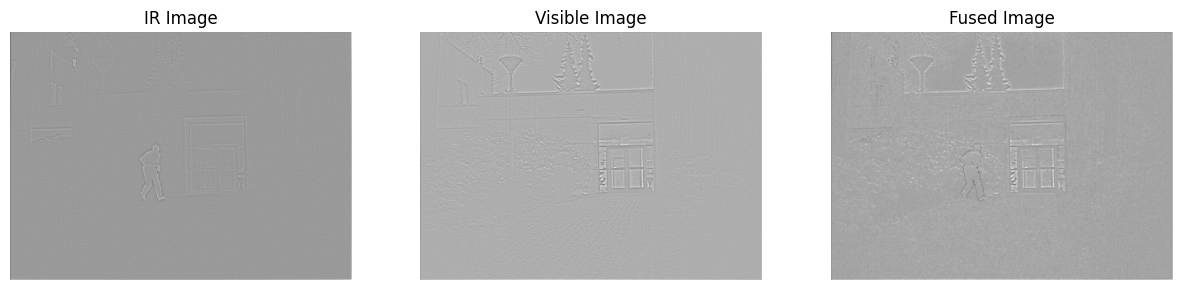

In [ ]:
import argparse
import cv2
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models.vgg import vgg19

class VGG19(torch.nn.Module):
    def __init__(self, device='cpu'):
        super(VGG19, self).__init__()
        features = list(vgg19(pretrained=True).features)
        if device == "cuda":
            self.features = nn.ModuleList(features).cuda().eval()
        else:
            self.features = nn.ModuleList(features).eval()

    def forward(self, x):
        feature_maps = []
        for idx, layer in enumerate(self.features):
            x = layer(x)
            if idx == 3:
                feature_maps.append(x)
        return feature_maps

class Fusion:
    def __init__(self, input):
        """
        Class Fusion constructor

        Instance Variables:
            self.images: input images
            self.model: CNN model, default=vgg19
            self.device: either 'cuda' or 'cpu'
        """
        self.input_images = input
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model = VGG19(self.device)

    def fuse(self):
        """
        A top level method which fuse self.images
        """
        # Convert all images to YCbCr format
        self.normalized_images = [-1 for img in self.input_images]
        for idx, img in enumerate(self.input_images):
                self.normalized_images[idx] = img / 255.
        # Transfer all images to PyTorch tensors
        self._tranfer_to_tensor()
        # Perform fuse strategy
        weights_list = self._fuse()

        return weights_list
        # return fused_img

    def _fuse(self):
      """
      Perform fusion algorithm and return weights for each image
      """
      with torch.no_grad():
          imgs_sum_maps = [-1 for tensor_img in self.images_to_tensors]
          for idx, tensor_img in enumerate(self.images_to_tensors):
              imgs_sum_maps[idx] = []
              feature_maps = self.model(tensor_img)
              for feature_map in feature_maps:
                  sum_map = torch.sum(feature_map, dim=1, keepdim=True)
                  imgs_sum_maps[idx].append(sum_map)

          weights_list = []  # Lưu trọng số của từng ảnh
          for sum_maps in zip(*imgs_sum_maps):
              features = torch.cat(sum_maps, dim=1)
              weights = self._softmax(F.interpolate(features, size=self.images_to_tensors[0].shape[2:]))
              weights = F.interpolate(weights, size=self.images_to_tensors[0].shape[2:])
              weights_list.append(weights.cpu().numpy())  # Chuyển sang NumPy để dễ xử lý

          return weights_list


    def _softmax(self, tensor):
            """
            A private method which compute softmax ouput of a given tensor
            """
            tensor = torch.exp(tensor)
            tensor = tensor / tensor.sum(dim=1, keepdim=True)
            return tensor

    def _tranfer_to_tensor(self):
            """
            A private method to transfer all input images to PyTorch tensors
            """
            self.images_to_tensors = []
            for image in self.normalized_images:
                np_input = image.astype(np.float32)
                if np_input.ndim == 2:
                    np_input = np.repeat(np_input[None, None], 3, axis=1)
                else:
                    np_input = np.transpose(np_input, (2, 0, 1))[None]
                if self.device == "cuda":
                    self.images_to_tensors.append(torch.from_numpy(np_input).cuda())
                else:
                    self.images_to_tensors.append(torch.from_numpy(np_input))

def solution_10(img_1, img_2, ir_norm, vis_norm):
    input_images = []
    input_images.append(img_1)
    input_images.append(img_2)

    # Compute fusion image
    FU = Fusion(input_images)
    weights_list = FU.fuse()

    fused_img = ir_norm * weights_list[0][0][0] + vis_norm * weights_list[0][0][1]

    return fused_img

#### DTCWT

In [30]:
import math
def get_energy(img):

    # vec = img.flatten()
    #  # Ma trận trọng số cho từng pixel trong ảnh (các cột 1,2,3 và các hàng 1,2,3): W = 1 / (1+sqrt((i-2)^2+(j-2)^2))
    # W = np.zeros((3,3))
    # for i in range(3):
    #     for j in range(3):
    #         W[i,j] = 1 / (1 + math.sqrt((i-1)**2 + (j-1)**2))

    vec = img.flatten()
    # Ma trận trọng số là ma trận Guassian 3x3
    W = np.array([[1, 2, 1], [2, 4, 2], [1, 2, 1]]) / 16

    # Tính năng lượng vùng của ảnh đầu vào bằng cách tính tổng bình phương của tích chập ảnh với ma trận trọng số
    energy = np.sum(W * (img**2))
    return energy

def maximum_region_energy(highpass_ir_sub, highpass_vis_sub, sz_h, sz_w):
    highpass_fused_sub = np.zeros_like(highpass_ir_sub, dtype=np.complex_)

    img_1 = np.abs(highpass_ir_sub)
    img_2 = np.abs(highpass_vis_sub)

     # Khởi tạo ảnh đầu ra với kích thước giống như ảnh đầu vào và đặt giá trị ban đầu bằng 0
    img_output = np.zeros(np.shape(img_1))
    # Kích thước cửa sổ trượt
    h = sz_h
    w = sz_w
    # Tính nửa kích thước cửa sổ để mở rộng ảnh
    ext_x = int(w / 2)
    ext_y = int(h / 2)
    # Mở rộng ảnh đầu vào theo chiều ngang
    edge_x = np.zeros([img_1.shape[0], ext_x], img_1.dtype)
    tem_img_1 = np.hstack((edge_x, img_1, edge_x))
    # Mở rộng ảnh đầu vào theo chiều dọc
    edge_y = np.zeros([ext_y, tem_img_1.shape[1]], img_1.dtype)
    ext_img_1 = np.vstack((edge_y, tem_img_1, edge_y))
    tem_img_2 = np.hstack((edge_x, img_2, edge_x))
    ext_img_2 = np.vstack((edge_y, tem_img_2, edge_y))

    # Duyệt qua từng pixel của ảnh đầu vào
    for y in range(0, img_1.shape[0]):
        for x in range(0, img_1.shape[1]):
            # Lấy cửa sổ trượt tương ứng từ mỗi ảnh mở rộng
            w_1 = ext_img_1[y:y+2*ext_y+1, x:x+2*ext_x+1]
            w_2 = ext_img_2[y:y+2*ext_y+1, x:x+2*ext_x+1]
            # Tính năng lượng vùng cho từng cửa sổ
            RE1 = abs(get_energy(w_1))
            RE2 = abs(get_energy(w_2))
            # Chiến lược ghép ảnh: chọn pixel từ ảnh có năng lượng vùng cao hơn
            if RE1 >= RE2:
                highpass_fused_sub[y, x] = highpass_ir_sub[y, x]
            elif RE1 < RE2:
                highpass_fused_sub[y, x] = highpass_vis_sub[y, x]

    return highpass_fused_sub

def solution_2_1(highpass_ir, highpass_vis):
    highpass_fused = np.zeros_like(highpass_ir, dtype=np.complex_)

    # Duyệt qua từng cặp highpass của ir và vis (mỗi thành phần có 6 thành phần con)
    for j in range(6):
        highpass_ir_sub = highpass_ir[:, :, j]
        highpass_vis_sub = highpass_vis[:, :, j]
        highpass_fused_sub = maximum_region_energy(highpass_ir_sub, highpass_vis_sub, sz_h=3, sz_w=3)
        highpass_fused[:, :, j] = highpass_fused_sub

    return highpass_fused

In [31]:
# Hàm tổng hợp hình ảnh
def get_test_image(image):
    images = []
    image = normalize_to_dynamic_range(image, 0, 255)
    image = np.reshape(image, [1, image.shape[0], image.shape[1]])
    images.append(image)
    images = np.stack(images, axis=0)
    image = torch.from_numpy(images).float().to(device)
    return image

def normalize_to_dynamic_range(layer, target_min=0, target_max=1):
    layer_min = layer.min()
    layer_max = layer.max()
    if layer_max == layer_min:
        return np.full(layer.shape, (target_min + target_max) / 2)
    else:
        normalized_layer = (layer - layer_min) / (layer_max - layer_min)
        normalized_layer = normalized_layer * (target_max - target_min) + target_min
        return normalized_layer

# Convert về dạng 8-bit và lưu ảnh
def convert_to_uint_255(layer):
    norm_layer = (layer - np.min(layer)) / (np.max(layer) - np.min(layer))  # Normalize to 0-1 range
    norm_layer = (norm_layer * 255).astype(np.uint8)  # Convert to uint8
    return norm_layer
    
def process_image_pair(ir_path, vis_path, model, output_path, fs_type, pair_id, prefix):
    img_ir = io.imread(ir_path)
    img_vis = io.imread(vis_path)

    if len(img_ir.shape) == 3:
        img_ir = color.rgb2gray(img_ir)
    if len(img_vis.shape) == 3:
        img_vis = color.rgb2gray(img_vis)
    
    img_ir_origin = util.img_as_float(img_ir)
    img_vis_origin = util.img_as_float(img_vis)
    max_levels = 1

    pyramid_ir = lp.dtcwt_pyramid.dtcwt_decompose(img_ir_origin, levels=max_levels)
    pyramid_vis = lp.dtcwt_pyramid.dtcwt_decompose(img_vis_origin, levels=max_levels)
    
    ''' OLD CODE
    # Sử dụng mô hình NestFuse để hợp nhất thành phần chi tiết
    with torch.no_grad():
        pyramid_detail_fusion = [None] * (max_levels - 1)
        for i in range(1, max_levels):
            pyramid_detail_ir = get_test_image(pyramid_ir[i])
            pyramid_detail_vis = get_test_image(pyramid_vis[i])
            img_ir = Variable(pyramid_detail_ir, requires_grad=False)
            img_vi = Variable(pyramid_detail_vis, requires_grad=False)

            en_r = model.encoder(img_ir)
            en_v = model.encoder(img_vi)
            f = model.fusion(en_r, en_v, fs_type)
            img_fusion_list = model.decoder_eval(f)

            for img_fusion in img_fusion_list:
                pyramid_detail_fusion[i - 1] = img_fusion.squeeze(0).squeeze(0).cpu().numpy()
                pyramid_detail_fusion[i - 1] = normalize_to_dynamic_range(pyramid_detail_fusion[i - 1], 0, 1)

    fused_pyramid = [None] * max_levels
    # fused_pyramid[0] = solution_10(pyramid_ir_convert, pyramid_vis_convert, pyramid_ir[0], pyramid_vis[0])
    fused_pyramid[0] = solution_2_1(pyramid_ir[0], pyramid_vis[0])

    fused_pyramid[1:] = pyramid_detail_fusion
    '''

    with torch.no_grad():
        pyramid_detail_fusion = None
        pyramid_detail_ir = get_test_image(pyramid_ir.lowpass)
        pyramid_detail_vis = get_test_image(pyramid_vis.lowpass)
        img_ir = Variable(pyramid_detail_ir, requires_grad=False)
        img_vi = Variable(pyramid_detail_vis, requires_grad=False)

        en_r = model.encoder(img_ir)
        en_v = model.encoder(img_vi)
        f = model.fusion(en_r, en_v, fs_type)
        img_fusion_list = model.decoder_eval(f)

        for img_fusion in img_fusion_list:
            pyramid_detail_fusion = img_fusion.squeeze(0).squeeze(0).cpu().numpy()
            pyramid_detail_fusion = normalize_to_dynamic_range(pyramid_detail_fusion, 0, 1)

    fused_pyramid = {
        "lowpass": pyramid_detail_fusion,
        "highpasses": [None] * max_levels
    }

    for i in range(max_levels):
        highpass_ir = pyramid_ir.highpasses[i]
        highpass_vis = pyramid_vis.highpasses[i]
        highpass_fused = solution_2_1(highpass_ir, highpass_vis)
        fused_pyramid["highpasses"][i] = highpass_fused
            

    # for i in range(1, max_levels+1):
    #     irH, irV, irD = pyramid_ir[i]
    #     visH, visV, visD = pyramid_vis[i]
    #     fusedH = solution_2_1(irH, visH)
    #     fusedV = solution_2_1(irV, visV)
    #     fusedD = solution_2_1(irD, visD)
    #     fused_pyramid.append((fusedH, fusedV, fusedD))
    
    fused_pyramid = SimpleNamespace(**fused_pyramid)
    img_fused = lp.dtcwt_pyramid.dtcwt_recompose(fused_pyramid)

    # fused_pyramid = [None] * max_levels
    # for i in range(max_levels - 1):
    #     fused_pyramid[i] = solution_2_1(pyramid_ir[i], pyramid_vis[i])

    # fused_pyramid[-1] = pyramid_detail_fusion

    # img_fused = lp.constrast_pyramid.reconstruct(fused_pyramid)

    output_path_fused = os.path.join(output_path, "fused_image.png")
    io.imsave(output_path_fused, img_as_ubyte(np.clip(img_fused, 0, 1)))
    print(output_path_fused)

    # Lưu pyramid_ir[0], pyramid_vis[0] và fused_pyramid[0] để so sánh
    pyramid_ir_0 = os.path.join(output_path, "ir.png")
    pyramid_vis_0 = os.path.join(output_path, "vis.png")
    fused_pyramid_0 = os.path.join(output_path, "fused.png")

    pyramid_ir_convert = convert_to_uint_255(pyramid_ir.lowpass)
    pyramid_vis_convert = convert_to_uint_255(pyramid_vis.lowpass)
    fused_pyramid_convert = convert_to_uint_255(fused_pyramid.lowpass)

    io.imsave(pyramid_ir_0, pyramid_ir_convert)
    io.imsave(pyramid_vis_0, pyramid_vis_convert)
    io.imsave(fused_pyramid_0, fused_pyramid_convert)

def find_matching_images(ir_folder, vis_folder):
    ir_images = {os.path.basename(path): path for path in glob.glob(os.path.join(ir_folder, '*.png'))}
    vis_images = {os.path.basename(path): path for path in glob.glob(os.path.join(vis_folder, '*.png'))}
    common_names = sorted(set(ir_images.keys()).intersection(set(vis_images.keys())))
    matching_pairs = [(ir_images[name], vis_images[name]) for name in common_names]
    return matching_pairs

def process_images(ir_folder, vis_folder, output_folder, model, fs_type, prefix):
    os.makedirs(output_folder, exist_ok=True)
    image_pairs = find_matching_images(ir_folder, vis_folder)
    for ir_path, vis_path in image_pairs:
        output_filename = os.path.basename(ir_path)
        # output_path = os.path.join(output_folder, output_filename)
        file_name_not_ext = os.path.splitext(output_filename)[0]
        output_path_folder = os.path.join(output_folder, file_name_not_ext)
        os.makedirs(output_path_folder, exist_ok=True)
        process_image_pair(ir_path, vis_path, model, output_path_folder, fs_type, output_filename, prefix)
        print(f"Processed and saved fusion image to {output_path_folder}")

In [9]:
output_folder = 'C:/PVH/SourceCode/LP+nestfuse/TNO_results/NestFuse'

In [10]:
from Indicator.show_indicator import show_indicator_csv

# list_code_image = [1, 2, 4, 6, 9, 10, 12, 13, 19, 20]

# Tạo file csv chứa kết quả đánh giá tổng hợp cho cả 10 nhóm ảnh trên
import csv
import pandas as pd
import os
from skimage import io

# Tạo file csv chứa kết quả đánh giá tổng hợp cho cả 10 nhóm ảnh trên
def create_csv_file(output_folder):
    # Tạo file csv chứa kết quả đánh giá tổng hợp cho cả 10 nhóm ảnh trên (kết quả lấy từ hàm show_indicator)
    csv_file = os.path.join(output_folder, 'result.csv')
    with open(csv_file, mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(['Code', 'MI', 'NMI', 'NCIE', 'QG', 'QM', 'SSIM', 'Qs_Piella', 'Qw_Piella', 'Qe_Piella', 'Yang', 'PSNR', 'EN', 'AG', 'SD', 'ALI', 'CC', 'VIF'])
        # for code in list_code_image:
        for number_image in range(1, 43):
            if number_image < 10:
                code = f'0{number_image}'
            else:
                code = f'{number_image}'
            ir = io.imread(f'C:/PVH/SourceCode/LP+nestfuse/TNO/ir/{code}.png')
            vi = io.imread(f'C:/PVH/SourceCode/LP+nestfuse/TNO/vi/{code}.png')
            fused = io.imread(f'C:/PVH/SourceCode/LP+nestfuse/TNO_results/NestFuse/fusion_nestfuse_{number_image}_subnet_0_attention_avg.png')
            MI, NMI, NCIE, QG, QM, SSIM, Qs_Piella, Qw_Piella, Qe_Piella, Yang, PSNR, EN, AG, SD, ALI, CC, VIF = show_indicator_csv(f"{code}", ir, vi, fused)
            writer.writerow([code, MI, NMI, NCIE, QG, QM, SSIM, Qs_Piella, Qw_Piella, Qe_Piella, Yang, PSNR, EN, AG, SD, ALI, CC, VIF])
            print(f"Done {code}")
        
    # Check if the CSV file is empty before reading it
    if os.path.getsize(csv_file) > 0:
        # Tính trung bình cộng của các chỉ số đánh giá
        df = pd.read_csv(csv_file)
        avg = df.mean()
        with open(csv_file, mode='a', newline='') as file:
            writer = csv.writer(file)
            writer.writerow(['Average', avg['MI'], avg['NMI'], avg['NCIE'], avg['QG'], avg['QM'], avg['SSIM'], avg['Qs_Piella'], avg['Qw_Piella'], avg['Qe_Piella'], avg['Yang'], avg['PSNR'], avg['EN'], avg['AG'], avg['SD'], avg['ALI'], avg['CC'], avg['VIF']]) 

    # Chuyển file csv thành file excel
    df = pd.read_csv(csv_file)
    df.to_excel(os.path.join(output_folder, 'result.xlsx'), index = False)

create_csv_file(output_folder)

Done 01
Done 02
Done 03
Done 04
Done 05
Done 06
Done 07
Done 08
Done 09
Done 10
Done 11
Done 12
Done 13
Done 14
Done 15
Done 16
Done 17
Done 18
Done 19
Done 20
Done 21
Done 22
Done 23
Done 24
Done 25
Done 26
Done 27
Done 28
Done 29
Done 30
Done 31
Done 32
Done 33
Done 34
Done 35
Done 36
Done 37
Done 38
Done 39
Done 40
Done 41
Done 42
